In [404]:
# author: netcan(https://github.com/netcan)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
%matplotlib inline

In [73]:
train_data = '../data/用例示例/TrainData_2015.1.1_2015.2.19.txt'
test_data = '../data/用例示例/TestData_2015.2.20_2015.2.27.txt'
df = pd.read_csv(train_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df_test = pd.read_csv(test_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df = df.append(df_test)
df['create_date'] = df['create_at'].apply(lambda x: x.date())

In [74]:
df.tail()

,vm-id,vm-name,create_at,create_date
56,56498dfb-80da,flavor9,2015-02-26 23:31:15,2015-02-26
57,56498dfc-91e7,flavor9,2015-02-26 23:31:25,2015-02-26
58,56498dfd-994c,flavor9,2015-02-26 23:31:52,2015-02-26
59,56498dfe-9564,flavor9,2015-02-26 23:31:52,2015-02-26
60,56498dff-a8d8,flavor9,2015-02-26 23:32:28,2015-02-26


In [261]:
interval = pd.date_range(df.create_date.min(), df.create_date.max()).tolist()

In [420]:
def get_flavors_complete(df):
    flavors_complete = {}
    interval = pd.date_range(df.create_date.min(), df.create_date.max()).tolist()
    for flavor in df['vm-name'].unique():
        f = df[df['vm-name'] == flavor].groupby('create_date')['vm-name'].count()
        for intval in interval:
            if intval.date() not in f:
                f = f.append(pd.Series({intval.date(): 0}))

        frame = f.to_frame().rename(columns={0: 'count'}).sort_index()
        frame['cumsum'] = frame['count'].cumsum()
        flavors_complete[flavor] = frame
    return flavors_complete
flavors_complete = get_flavors_complete(df) # 补齐日期，没有的补0个

In [338]:
predict_vm = range(1, 6)

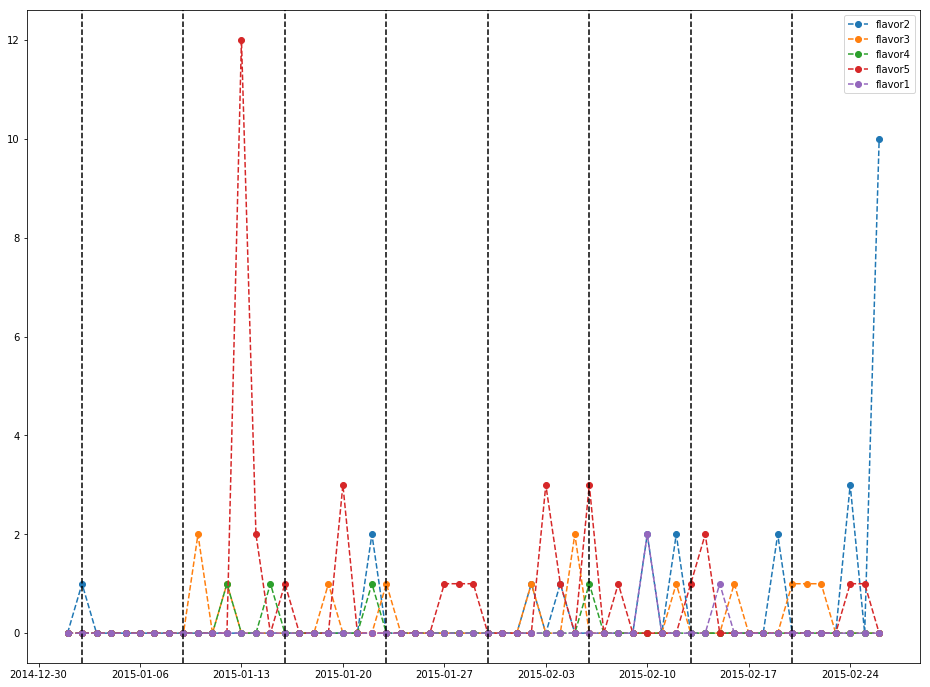

In [428]:
def plot_per_vm_count(flavors_complete):
    plt.figure(figsize=(16, 12))
    predict_date = date(2015, 2, 20)
    for vm_name, flavor in flavors_complete.items(): 
        if int(vm_name[6:]) in predict_vm:
            plt.plot(flavor.index, flavor['count'], 'o--', label=vm_name)

    start_date = predict_date
    while start_date in flavor.index:
        plt.axvline(x=start_date, color='k', linestyle='--')
        start_date -= timedelta(days=during_days)
    plt.legend()

plot_per_vm_count(flavors_complete)

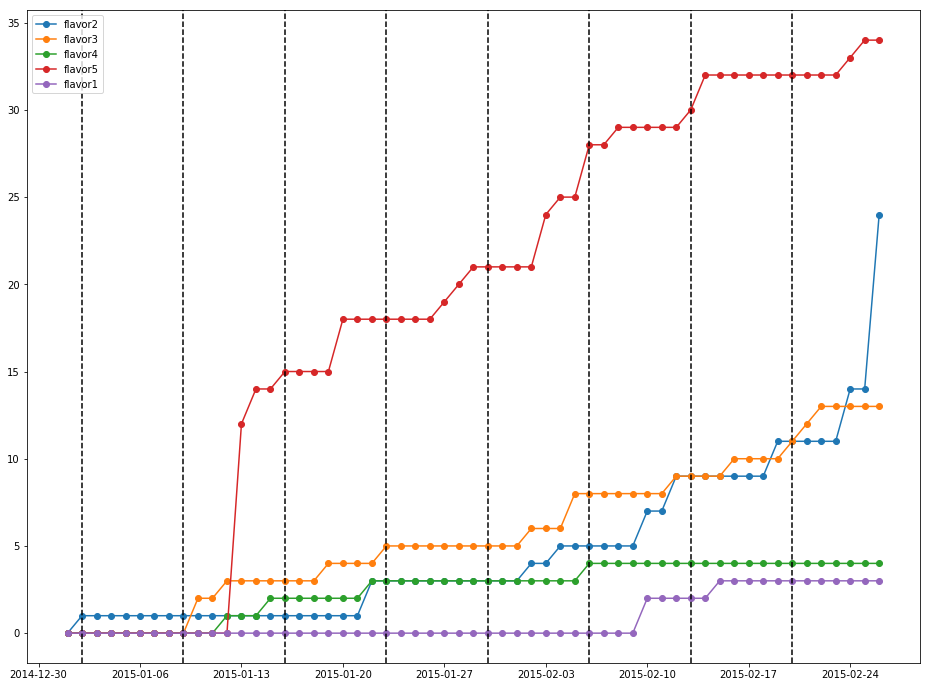

In [430]:
def plot_per_vm_cumsum(flavors_complete):
    plt.figure(figsize=(16, 12))
    for vm_name, flavor in flavors_complete.items():
        if int(vm_name[6:]) in predict_vm:
            plt.plot(flavor.index, flavor['cumsum'], 'o-', label=vm_name)

    start_date = predict_date
    while start_date in flavor.index:
        plt.axvline(x=start_date, color='k', linestyle='--')
        start_date -= timedelta(days=during_days)
    plt.legend()
plot_per_vm_cumsum(flavors_complete)

In [280]:
f15 = flavors_complete['flavor15']
f15.loc[date(2015, 1, 1):date(2015, 1, 8)]['count'].sum()

6

In [281]:
def getCount(vm_name, start_date, during_days):
    flavor = flavors_complete[vm_name]
    if start_date in flavor.index: 
        return flavor.loc[start_date:start_date + timedelta(days=during_days-1)]['count'].sum()
    return None

In [282]:
def shell_coefficient(y, Y):
    """y预测值， Y真实值"""
    return \
    np.sqrt(np.average( [(y[i] - Y[i])**2 for i in range(len(y))] )) / \
    ( np.sqrt(np.average( [y[i] ** 2 for i in range(len(y))] )) + np.sqrt(np.average( [Y[i] ** 2 for i in range(len(y))] )))

In [413]:
fmt = '{:>10}{:>10}{:>10}{:>10}'
print(fmt.format('vm-name', 'last7', 'next7', 'diff'))
for vm_name in flavors_complete:
    if int(vm_name[6:]) in predict_vm:
        last7 = getCount(vm_name, date(2015, 2, 13), 7)
        next7 = getCount(vm_name, date(2015, 2, 20), 7)
        print(fmt.format(vm_name, last7, next7, next7 - last7))

   vm-name     last7     next7      diff
   flavor2         2        13        11
   flavor3         1         3         2
   flavor4         0         0         0
   flavor5         3         2        -1
   flavor1         1         0        -1


In [374]:
shell_coefficient(
    [getCount('flavor' + str(vm), date(2015, 2, 13), 7) for vm in predict_vm],
    [getCount('flavor' + str(vm), date(2015, 2, 20), 7) for vm in predict_vm]
)

0.64902147001557908

In [285]:
getCount('flavor1', date(2015, 2, 13), 7)

1

In [328]:
during_days = 7
flavors_intval_count = {}
for vm_name in flavors_complete:
    intval_count = {}
    start_date = predict_date
    count = getCount(vm_name, start_date, during_days)
    while count is not None:
        intval_count[start_date] = count
        start_date -= timedelta(days=during_days)
        count = getCount(vm_name, start_date, during_days)
    flavors_intval_count[vm_name] = pd.Series(intval_count)

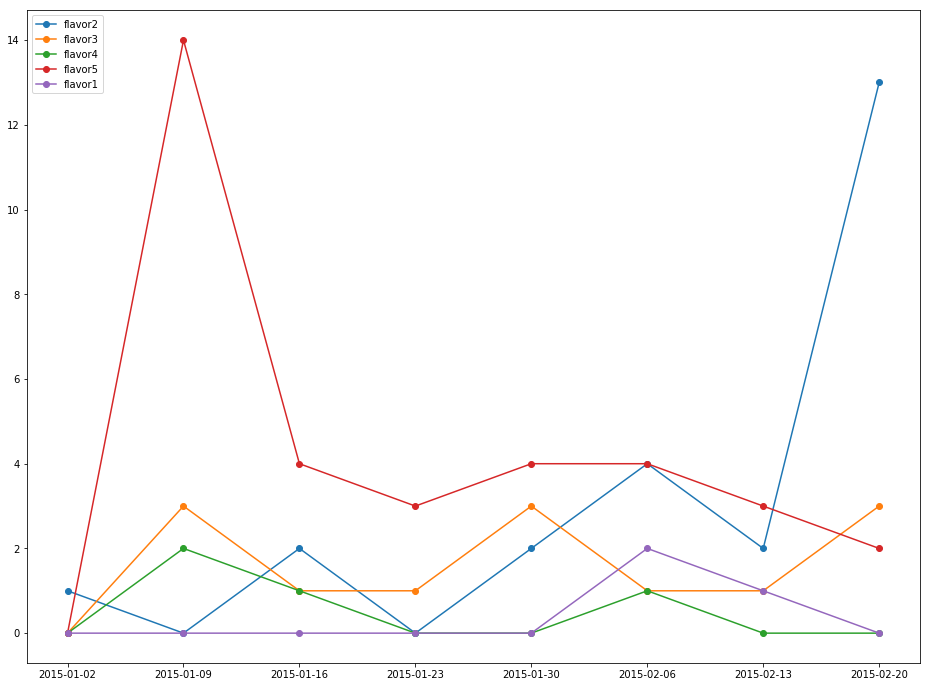

In [341]:
plt.figure(figsize=(16, 12))
for vm_name, flavor in flavors_intval_count.items():  
    if int(vm_name[6:]) in predict_vm:
        plt.plot(flavor, 'o-', label=vm_name)
plt.legend()

In [412]:
flavors_intval_count['flavor1']

2015-01-02    0
2015-01-09    0
2015-01-16    0
2015-01-23    0
2015-01-30    0
2015-02-06    2
2015-02-13    1
2015-02-20    0
dtype: int64

In [376]:
predict_date

datetime.date(2015, 2, 20)

In [424]:
combine_data = '../data/练习数据/combine_data_2015_1-5.txt'
cmb_df = pd.read_csv(combine_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
cmb_df['create_date'] = cmb_df['create_at'].apply(lambda x: x.date())

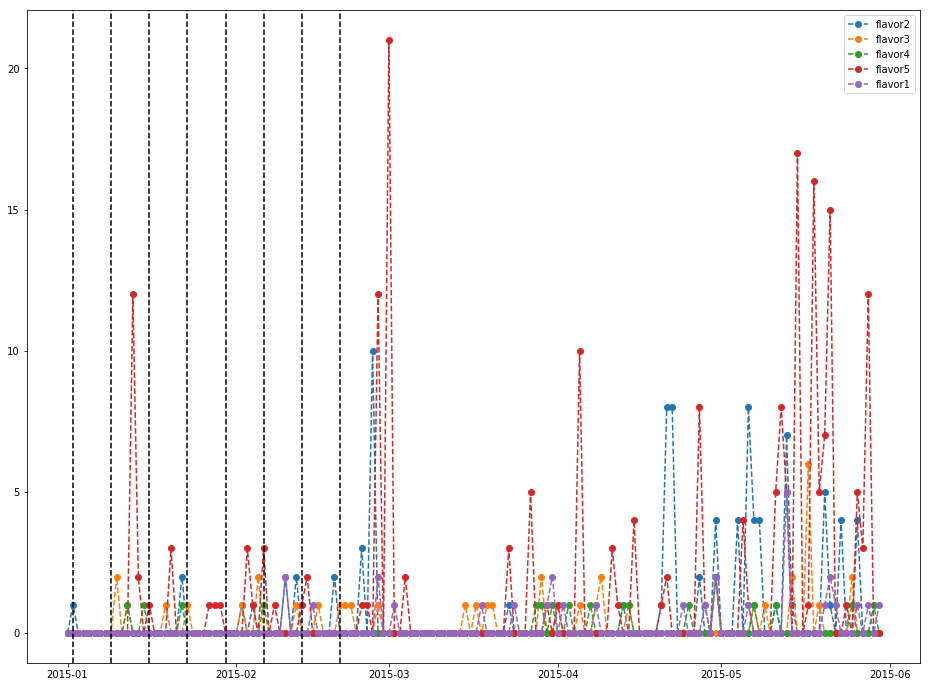

In [425]:
cmb_flavors_complete = get_flavors_complete(cmb_df)
plot_per_vm_count(cmb_flavors_complete)

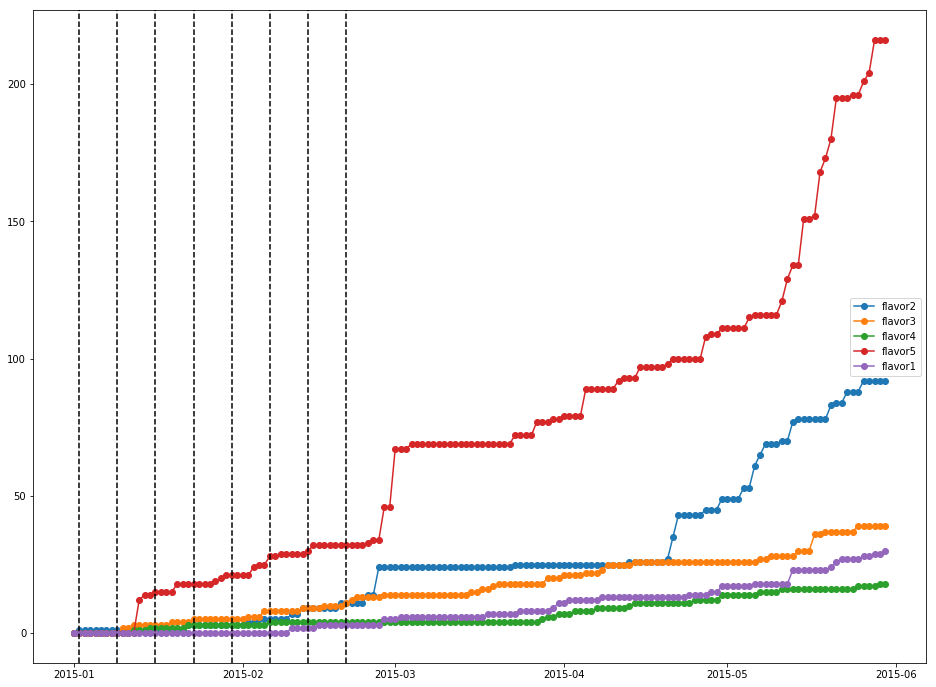

In [431]:
plot_per_vm_cumsum(cmb_flavors_complete)